# Quantum process tomography

This notebook loosely follows through the examples in the [corresponding Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/6b_process_tomography.ipynb).

We perform quantum process tomography for two cases: a Hadamard gate, and a CNOT gate.

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit. Others are for fun.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Notebook widget for watching IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmq_ourense


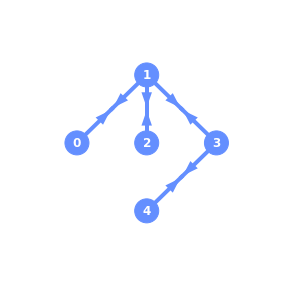

In [3]:
# Set least busy device as backend.
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_gate_map, plot_circuit_layout

small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                   and not x.configuration().simulator)
backend = least_busy(small_devices)
backend = provider.get_backend('ibmq_ourense')

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration.
print(backend)
plot_gate_map(backend, plot_directed=True)

## Example 1: X gate

### X gate circuit

In [4]:
# X gate
qr = QuantumRegister(1)
x = QuantumCircuit(qr)
x.x(0)
print(x)

# Measurement circuit.
cr = ClassicalRegister(1)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure(0, 0)
print(x+meas)

         ┌───┐
q0_0: |0>┤ X ├
         └───┘
         ┌───┐ ░ ┌─┐
q0_0: |0>┤ X ├─░─┤M├
         └───┘ ░ └╥┘
 c0_0: 0 ═════════╩═
                    


### Output of the X gate

In [5]:
# Run X gate.
job = execute(x+meas, backend, optimization_level=0, shots=5000)
print(job.job_id())

counts = job.result().get_counts()
print(counts)

# Simulate X gate.
counts_sim = execute(x+meas, simulator, shots=5000).result().get_counts()

5e49d149e2319f0018fe9f52
{'1': 4849, '0': 151}


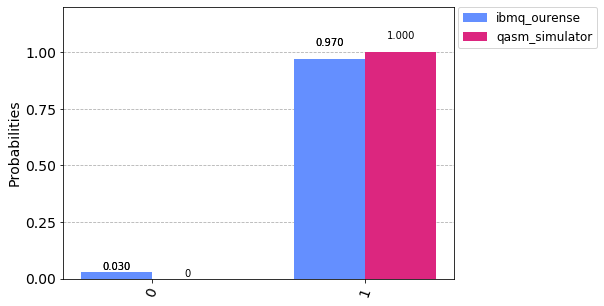

In [6]:
# Results from backend vs simulator.
from qiskit.visualization import plot_histogram
plot_histogram([counts, counts_sim], legend=[backend, simulator])

### Process tomography on the X gate

In [9]:
# Circuits for process tomography.
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
qpt_x = process_tomography_circuits(x, qr[0])

# Print circuits.
for circ in qpt_x:
    print(circ)

          ░ ┌───┐ ░ ┌───┐┌─┐
q0_0: |0>─░─┤ X ├─░─┤ H ├┤M├
          ░ └───┘ ░ └───┘└╥┘
 c3_0: 0 ═════════════════╩═
                            
          ░ ┌───┐ ░ ┌─────┐┌───┐┌─┐
q0_0: |0>─░─┤ X ├─░─┤ Sdg ├┤ H ├┤M├
          ░ └───┘ ░ └─────┘└───┘└╥┘
 c3_0: 0 ════════════════════════╩═
                                   
          ░ ┌───┐ ░ ┌─┐
q0_0: |0>─░─┤ X ├─░─┤M├
          ░ └───┘ ░ └╥┘
 c3_0: 0 ════════════╩═
                       
         ┌───┐ ░ ┌───┐ ░ ┌───┐┌─┐
q0_0: |0>┤ X ├─░─┤ X ├─░─┤ H ├┤M├
         └───┘ ░ └───┘ ░ └───┘└╥┘
 c3_0: 0 ══════════════════════╩═
                                 
         ┌───┐ ░ ┌───┐ ░ ┌─────┐┌───┐┌─┐
q0_0: |0>┤ X ├─░─┤ X ├─░─┤ Sdg ├┤ H ├┤M├
         └───┘ ░ └───┘ ░ └─────┘└───┘└╥┘
 c3_0: 0 ═════════════════════════════╩═
                                        
         ┌───┐ ░ ┌───┐ ░ ┌─┐
q0_0: |0>┤ X ├─░─┤ X ├─░─┤M├
         └───┘ ░ └───┘ ░ └╥┘
 c3_0: 0 ═════════════════╩═
                            
         ┌───┐ ░ ┌───┐ ░ ┌───┐┌─┐
q

In [10]:
# Process tomography circuits on backend.
job = execute(qpt_x, backend, optimization_level=0, shots=5000)
print(job.job_id())

5e49d1a7f451ab00187ecccb


In [11]:
# Calculate tomography data.
tomo_x = ProcessTomographyFitter(job.result(), qpt_x)
tomo_x.data

{(('Zp',), ('X',)): {'1': 2502, '0': 2498},
 (('Zp',), ('Y',)): {'1': 2384, '0': 2616},
 (('Zp',), ('Z',)): {'1': 4868, '0': 132},
 (('Zm',), ('X',)): {'1': 2391, '0': 2609},
 (('Zm',), ('Y',)): {'1': 2489, '0': 2511},
 (('Zm',), ('Z',)): {'1': 58, '0': 4942},
 (('Xp',), ('X',)): {'1': 71, '0': 4929},
 (('Xp',), ('Y',)): {'1': 2314, '0': 2686},
 (('Xp',), ('Z',)): {'1': 2449, '0': 2551},
 (('Yp',), ('X',)): {'1': 2466, '0': 2534},
 (('Yp',), ('Y',)): {'1': 4858, '0': 142},
 (('Yp',), ('Z',)): {'1': 2413, '0': 2587}}

CP? True. TP? False.


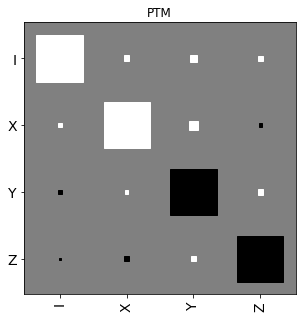

In [12]:
# Extracting the PTM.
from qiskit.quantum_info import PTM
choi_x = tomo_x.fit()
ptm_x = PTM(choi_x)
print('CP? '+str(ptm_x.is_cp())+'.', 'TP? '+str(ptm_x.is_tp())+'.')

# Plot Hinton diagram of PTM.
from qiskit.visualization import plot_state_hinton
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_state_hinton(ptm_x.data, ax_real=ax)

ax.set_title(r'PTM');
ax.set_xticklabels(['I', 'X', 'Y', 'Z']);
ax.set_yticklabels(['I', 'X', 'Y', 'Z']);

## Example 2: CNOT gate

### CNOT gate circuit

In [14]:
# CNOT gate.
qr = QuantumRegister(2)
cnot = QuantumCircuit(qr)
cnot.cx(0, 1)
print(cnot)

# Measurement circuit.
cr = ClassicalRegister(2)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure([0,1], [0,1])
print(cnot+meas)

              
q2_0: |0>──■──
         ┌─┴─┐
q2_1: |0>┤ X ├
         └───┘
               ░ ┌─┐   
q2_0: |0>──■───░─┤M├───
         ┌─┴─┐ ░ └╥┘┌─┐
q2_1: |0>┤ X ├─░──╫─┤M├
         └───┘ ░  ║ └╥┘
 c5_0: 0 ═════════╩══╬═
                     ║ 
 c5_1: 0 ════════════╩═
                       


### Output of the CNOT gate

In [15]:
# Run Hadamard circuit.
job = execute(cnot+meas, backend, optimization_level=0, shots=5000)
print(job.job_id())

counts = job.result().get_counts()
print(counts)

# Simulate Hadamard ciruit.
counts_sim = execute(cnot+meas, simulator, shots=5000).result().get_counts()

5e49d273c3369900189f41b5
{'10': 102, '11': 69, '01': 28, '00': 4801}


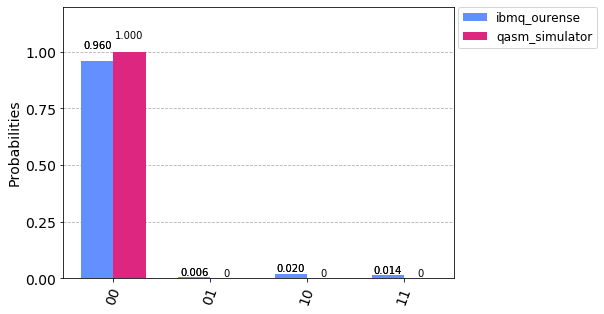

In [16]:
# Results from backend vs simulator.
from qiskit.visualization import plot_histogram
plot_histogram([counts, counts_sim], legend=[backend, simulator])

### Process tomography for a CNOT gate

In [17]:
# Calculate circuits for process tomography.
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
qpt_cnot = process_tomography_circuits(cnot, [qr[0], qr[1]])
print(len(qpt_cnot))

144


In [18]:
# Batched process tomography circuits on backend.
result = []
for n in range(len(qpt_cnot)//50 + 1):
    job = execute(qpt_cnot[n*50: (n+1)*50], backend, optimization_level=0, shots=5000)
    result.append(job.result())
    print(job.job_id())

5e49d2d0d686050018c27964
5e49d41de2319f0018fe9f6f
5e49d542b917c90018a16d7a


In [22]:
# Calculate tomography data.
tomo_cnot = []
tomo_cnot = ProcessTomographyFitter(result[0], qpt_cnot[:50])
for n in range(1, len(qpt_cnot)//50 + 1):
    tomo_cnot.add_data(result[n], qpt_cnot[n*50 : (n+1)*50])
tomo_cnot.data

{(('Zp', 'Zp'), ('X', 'X')): {'10': 1496, '11': 1344, '01': 993, '00': 1167},
 (('Zp', 'Zp'), ('X', 'Y')): {'10': 1345, '11': 1307, '01': 1074, '00': 1274},
 (('Zp', 'Zp'), ('X', 'Z')): {'10': 71, '11': 81, '01': 2269, '00': 2579},
 (('Zp', 'Zp'), ('Y', 'X')): {'10': 1410, '11': 1436, '01': 991, '00': 1163},
 (('Zp', 'Zp'), ('Y', 'Y')): {'10': 1424, '11': 1307, '01': 1105, '00': 1164},
 (('Zp', 'Zp'), ('Y', 'Z')): {'10': 89, '11': 89, '01': 2380, '00': 2442},
 (('Zp', 'Zp'), ('Z', 'X')): {'10': 2792, '11': 49, '01': 38, '00': 2121},
 (('Zp', 'Zp'), ('Z', 'Y')): {'10': 2592, '11': 26, '01': 47, '00': 2335},
 (('Zp', 'Zp'), ('Z', 'Z')): {'10': 132, '11': 60, '01': 23, '00': 4785},
 (('Zp', 'Zm'), ('X', 'X')): {'10': 1501, '11': 1275, '01': 1014, '00': 1210},
 (('Zp', 'Zm'), ('X', 'Y')): {'10': 1230, '11': 964, '01': 1324, '00': 1482},
 (('Zp', 'Zm'), ('X', 'Z')): {'10': 2549, '11': 2159, '01': 141, '00': 151},
 (('Zp', 'Zm'), ('Y', 'X')): {'10': 1393, '11': 1428, '01': 1053, '00': 1126},

CP? True. TP? False.


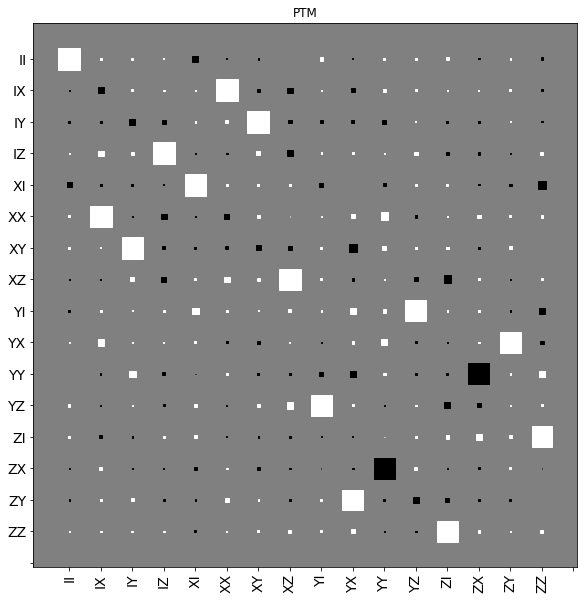

In [25]:
# Extracting the PTM.
from qiskit.quantum_info import PTM
choi_cnot = tomo_cnot.fit()
ptm_cnot = PTM(choi_cnot)
print('CP? '+str(ptm_cnot.is_cp())+'.', 'TP? '+str(ptm_cnot.is_tp())+'.')

# Plot Hinton diagram of PTM.
from qiskit.visualization import plot_state_hinton
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_state_hinton(ptm_cnot.data, ax_real=ax)

labels = []
paulis = ['I', 'X', 'Y', 'Z']
for i in range(4):
    for j in range(4):
        labels.append(paulis[i]+paulis[j])
            
ax.set_title('PTM');
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);